<a href="https://colab.research.google.com/github/huaqiwen/JSC270_Assg2/blob/qiwen-hua/JSC270_Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Libraries you'll likely need

In [160]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

###Importing data

In [161]:
income94 = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', header=None)
income94.columns = ['age','workclass', 'fnlwgt','education','education_num','marital_status','occupation',
                    'relationship','race','sex','capital_gain','capital_loss','hours_per_week','native_country','gross_income_group']

# peek the dataframe
income94.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,gross_income_group
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


## Initial data exploration

### 1. Check the columns and their types
- They are the expected data types: int64 for continuous variables and object for categorical variables.

In [162]:
income94.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   age                 32561 non-null  int64 
 1   workclass           32561 non-null  object
 2   fnlwgt              32561 non-null  int64 
 3   education           32561 non-null  object
 4   education_num       32561 non-null  int64 
 5   marital_status      32561 non-null  object
 6   occupation          32561 non-null  object
 7   relationship        32561 non-null  object
 8   race                32561 non-null  object
 9   sex                 32561 non-null  object
 10  capital_gain        32561 non-null  int64 
 11  capital_loss        32561 non-null  int64 
 12  hours_per_week      32561 non-null  int64 
 13  native_country      32561 non-null  object
 14  gross_income_group  32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


### 2. Handle missing values
- The info file (adult.names) states that all unknowns are labeled by `"?"`. However, after converting all `"?"` to `np.NaN`, we see that only `workclass`, `occupation`, `native_country` have missing values. 

In [163]:
income94 = income94.replace(' ?', np.NaN)
income94.isna().sum()

age                      0
workclass             1836
fnlwgt                   0
education                0
education_num            0
marital_status           0
occupation            1843
relationship             0
race                     0
sex                      0
capital_gain             0
capital_loss             0
hours_per_week           0
native_country         583
gross_income_group       0
dtype: int64

### 3. Distribution of `capital_gain` and `capital_loss`

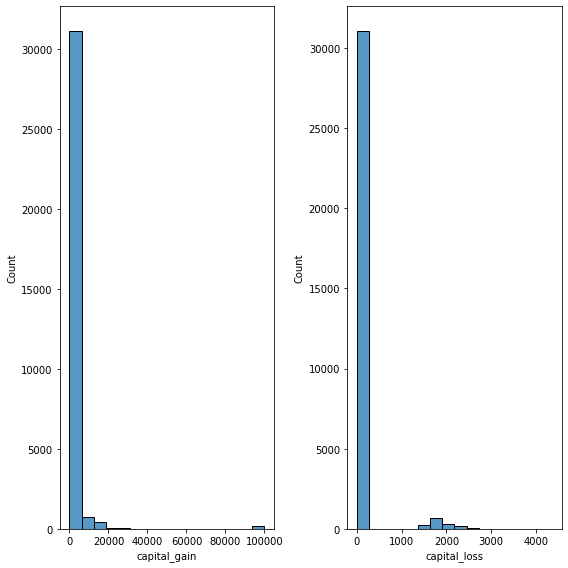

In [164]:
fig, ax = plt.subplots(1, 2, figsize=(8, 8))
sns.histplot(income94["capital_gain"], ax=ax[0])
sns.histplot(income94["capital_loss"], ax=ax[1])

fig.tight_layout()      # add some spacing between subplots
fig.show()

The variables should be transformed as the distribution is extremely skewed due to the large number of zeros.

In [165]:
income94["should_trans_cg"] = income94["capital_gain"].map(lambda x : x == 0, na_action=None)
income94["should_trans_cl"] = income94["capital_loss"].map(lambda x : x == 0, na_action=None)

print("=== Number of zeros in capital_gain ===")
display(income94["should_trans_cg"].value_counts())

print("\n=== Number of zeros in capital_loss ===")
display(income94["should_trans_cl"].value_counts())

=== Number of zeros in capital_gain ===


True     29849
False     2712
Name: should_trans_cg, dtype: int64


=== Number of zeros in capital_loss ===


True     31042
False     1519
Name: should_trans_cl, dtype: int64

### 4. Explore `fnlwgt` (weight)
- the data is heavily right skewed
- the distribution between men and women are similar 
- the outliers should not be excluded as that would make the data set under representing some people

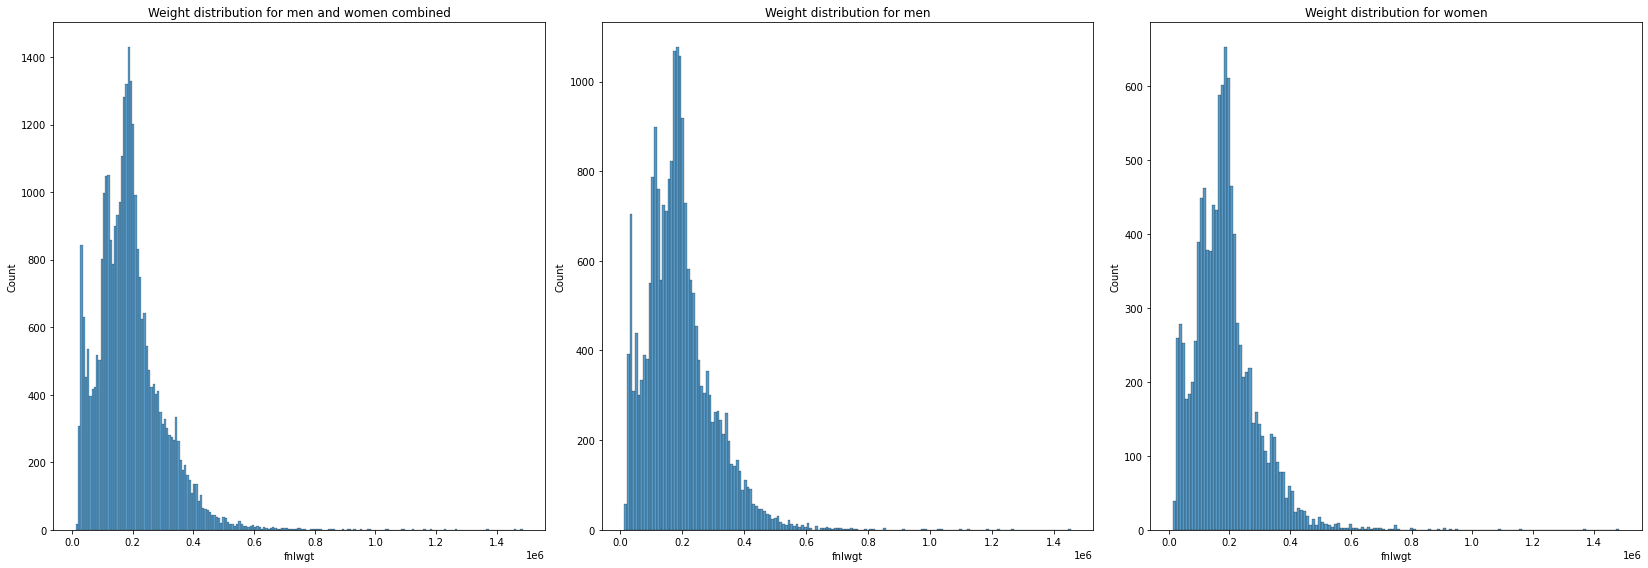

In [166]:
fig, ax = plt.subplots(1, 3, figsize=(23, 8))
sns.histplot(income94["fnlwgt"], ax=ax[0])
sns.histplot(income94[income94["sex"] == " Male"]["fnlwgt"], ax=ax[1])
sns.histplot(income94[income94["sex"] == " Female"]["fnlwgt"], ax=ax[2])

# add titles
ax[0].title.set_text("Weight distribution for men and women combined")
ax[1].title.set_text("Weight distribution for men")
ax[2].title.set_text("Weight distribution for women")

fig.tight_layout()      # add some spacing between subplots
fig.show()

# set all outliers in "fnlwgt" to NaN
lb = income94["fnlwgt"].quantile(0.01)
ub = income94["fnlwgt"].quantile(0.99)
#income94.loc[(income94.fnlwgt > ub) | (income94.fnlwgt < lb), "fnlwgt"] = np.nan

## Correlation

### a. `education_num` and `hours_per_week` appear to have a very weak negative correlation

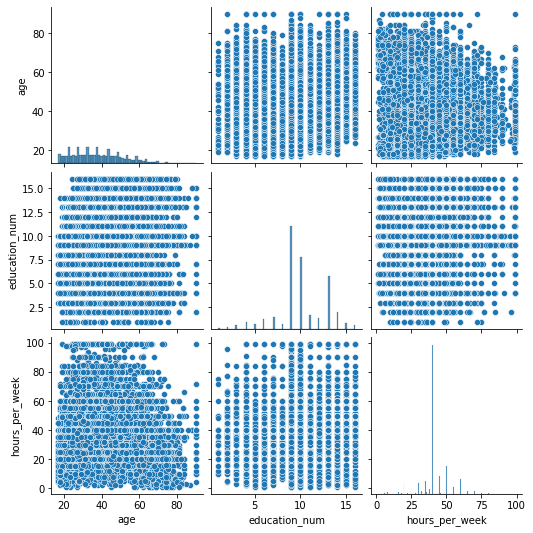

In [150]:
sns.pairplot(income94[['age', 'education_num', 'hours_per_week']])

### b. the correlation coefficient between `education_num` and `hours_per_week` is greater than $0.1$ and is indeed positive.  

In [151]:
income94[["age", "education_num", "hours_per_week"]].corr()

,age,education_num,hours_per_week
age,1.000000,0.036527,0.068756
education_num,0.036527,1.000000,0.148123
hours_per_week,0.068756,0.148123,1.000000


### c. the correlation between `education_num` and `age` is positive (0.060) for male participants while negative (-0.018) for female participants. 
- The dataset is drawn from a census in 1994, thus it is likely that elderly women at that time did not have the chance to receive adequate education (from [Timeline of women's education](https://en.wikipedia.org/wiki/Timeline_of_women%27s_education) we see that women starts to get education only from late 19th century to early 20th century). Therefore we see the slightly negative correlation between `education_num` and `age` of female participants. 
- The correlation for male participants is positive as expected, as people get more chance to education as they age.

In [152]:
print("=== Correlation between education_num and age of male participants ===")
display(income94[income94["sex"] == " Male"][["age", "education_num"]].corr())

print("\n=== Correlation between education_num and age of female participants ===")
display(income94[income94["sex"] == " Female"][["age", "education_num"]].corr())

=== Correlation between education_num and age of male participants ===


,age,education_num
age,1.000000,0.060486
education_num,0.060486,1.000000



=== Correlation between education_num and age of female participants ===


,age,education_num
age,1.000000,-0.017899
education_num,-0.017899,1.000000


### d. weighted and unweighted variance and covariance between `education_num` and `hours_per_week`
- We can see that the female group is under represented as the total weight for female participants is less than half of the one for male participants. 

In [153]:
""" Find and return the weighted variance of input series """
def get_weighted_var(series, weights):
    exp = np.average(series, weights=weights)
    var = np.average((series-exp) ** 2, weights=weights)
    return var


""" Find and return the weight covariance of input series """
def get_weighted_cov(sa, sb, weights):
    # the formula for the weighted covariance is from https://en.wikipedia.org/wiki/Pearson_correlation_coefficient#Weighted_correlation_coefficient 
    return np.sum(weights * (sa - np.average(sa, weights=weights)) * (sb - np.average(sb, weights=weights))) / np.sum(weights)

In [169]:
# Find variance
print("=== Variance of education_num ===")
print("unweighted:", income94.education_num.var())
print("weighted:  ", get_weighted_var(income94.education_num, income94.fnlwgt))

print("")
print("=== Variance of hours_per_week ===")
print("unweighted:", income94.hours_per_week.var())
print("weighted:  ", get_weighted_var(income94.hours_per_week, income94.fnlwgt))
 
# Find covariance
print("\n=== unweighted covariance between education_num and hours_per_week ===")
display(income94.education_num.cov(income94.hours_per_week))
print("\n=== weighted covariance between education_num and hours_per_week ===")
display(get_weighted_cov(income94.education_num, income94.hours_per_week, income94.fnlwgt))

# Find weight diff between men and women
print("\n=== group weights ===")
print("Men:   ", np.sum(income94[income94.sex == " Male"].fnlwgt))
print("Female:", np.sum(income94[income94.sex == " Female"].fnlwgt))

=== Variance of education_num ===
unweighted: 6.618889907032687
weighted:   6.828646539770926

=== Variance of hours_per_week ===
unweighted: 152.45899505042865
weighted:   146.3306330028469

=== unweighted covariance between education_num and hours_per_week ===


4.705337944611544


=== weighted covariance between education_num and hours_per_week ===


4.633888414261756


=== group weights ===
Men:    4178699874
Female: 2000673518


## Regression

### a. model for `hours_per_week` with only `sex`
- From the result of the regression model, $\beta_0 = 36.41$ and $\beta_1 = 6.02$. Since we mapped "Male" to 1 and "Female" to 0 in the regression model, $\beta_1$ tells us that men tend to work more hours (6.02).

In [155]:
# add a new variable that maps sex (Male = 1, Female = 0)
income94["sex_bin"] = income94.sex.map(lambda x : 1 if x == " Male" else 0)

In [156]:
Y = income94.hours_per_week
X = income94.sex_bin
X = sm.add_constant(X)      # add beta_0 to the model
model1 = sm.OLS(Y, X).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         hours_per_week   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     1807.
Date:                Sun, 07 Feb 2021   Prob (F-statistic):               0.00
Time:                        04:07:09   Log-Likelihood:            -1.2716e+05
No. Observations:               32561   AIC:                         2.543e+05
Df Residuals:                   32559   BIC:                         2.543e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         36.4104      0.116    314.412      0.000      36.183      36.637
sex_bin        6.0177      0.142     42.510      0.000       5.740       6.295
==============================================================================
Omnibus:                     2649.390   Durbin-Watson:                   2.019
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            13090.867
Skew:                           0.239   Prob(JB):                         0.00
Kurtosis:                       6.069   Cond. No.                         3.24
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### b. add `education_num` as a control variable
- The trend in hours worked by men vs women decreases very slightly (from 6.02 to 5.97). `education_num` is reasonably significant as it increases the R-squared value from 0.053 to 0.074.

In [157]:
Y = income94.hours_per_week
X = income94[["sex_bin", "education_num"]]
X = sm.add_constant(X)
model2 = sm.OLS(Y, X).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         hours_per_week   R-squared:                       0.074
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     1295.
Date:                Sun, 07 Feb 2021   Prob (F-statistic):               0.00
Time:                        04:07:09   Log-Likelihood:            -1.2680e+05
No. Observations:               32561   AIC:                         2.536e+05
Df Residuals:                   32558   BIC:                         2.536e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            29.4106      0.281    104.556      0.000      28.859      29.962
sex_bin           5.9709      0.140     42.653      0.000       5.697       6.245
education_num     0.6975      0.026     27.244      0.000       0.647       0.748
==============================================================================
Omnibus:                     2783.881   Durbin-Watson:                   2.018
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14492.060
Skew:                           0.247   Prob(JB):                         0.00
Kurtosis:                       6.231   Cond. No.                         45.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### c. add `gross_income_group` as a binary variable
- I would choose the "R-squared" statistic as it represents the percentage of variance for `hours_per_week` that are represented by the independet variables.
- I would use forward selection.
    1. start with a null model
    2. among all the variables (assume we have *n* of them), fit *n* models each with 1 variable, then choose the one with the highest R-squared
    3. repeat step 2 for the remaining un-used variables and add variables one at a time to the current model
    4. stop until R-squared stops increasing or we used-up all variables

In [158]:
# add a new variable that maps gross_income_group (<=50K = 0, >50K = 1)
income94["gig_bin"] = income94.gross_income_group.map(lambda x : 1 if x == " >50K" else 0)

In [159]:
Y = income94.hours_per_week
X = income94[["sex_bin", "education_num", "gig_bin"]]
X = sm.add_constant(X)
model3 = sm.OLS(Y, X).fit()
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         hours_per_week   R-squared:                       0.094
Model:                            OLS   Adj. R-squared:                  0.094
Method:                 Least Squares   F-statistic:                     1130.
Date:                Sun, 07 Feb 2021   Prob (F-statistic):               0.00
Time:                        04:07:10   Log-Likelihood:            -1.2643e+05
No. Observations:               32561   AIC:                         2.529e+05
Df Residuals:                   32557   BIC:                         2.529e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            31.4218      0.288    109.184      0.000      30.858      31.986
sex_bin           5.1010      0.142     35.907      0.000       4.823       5.379
education_num     0.4478      0.027     16.632      0.000       0.395       0.501
gig_bin           4.5175      0.166     27.229      0.000       4.192       4.843
==============================================================================
Omnibus:                     2984.190   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            15467.160
Skew:                           0.296   Prob(JB):                         0.00
Kurtosis:                       6.324   Cond. No.                         48.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""